<a href="https://colab.research.google.com/github/yufengsjtu/DL_learn/blob/main/Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import torch
from torch import nn
import numpy as np

def accuracy(y_hat, y): 
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())
class Accumulator:
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
def evaluate_accuracy_gpu(net,data_iter,device=None):
  if isinstance(net,torch.nn.Module):
    net.eval()
    if not device:
      device = next(iter(net.parameters())).device
  metric = Accumulator(2)
  for X,y in data_iter:
    if isinstance(X,list):
      X = [x.to(device) for x in X]
    else:
      X = X.to(device)
    y = y.to(device)
    metric.add(accuracy(net(X),y),y.numel())
  return metric[0]/metric[1]

import torchvision
from torch.utils import data
from torchvision import transforms
batch_size = 256
def load_fashion_minst_dataset(batch_size,resize=None):
  trans = [transforms.ToTensor()]
  if resize:
    trans.insert(0, transforms.Resize(resize))
  trans = transforms.Compose(trans)
  mnist_train = torchvision.datasets.FashionMNIST(
        root="./sample_data", train=True, transform=trans, download=True)
  mnist_test = torchvision.datasets.FashionMNIST(
        root="./sample_data", train=False, transform=trans, download=True)
  return (data.DataLoader(mnist_train, batch_size, shuffle=True,num_workers=4),
      data.DataLoader(mnist_test, batch_size, shuffle=False,num_workers=4))
  
import matplotlib.pyplot as plt
def train(net,train_iter,test_iter,num_epochs,lr,device):
  def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
      nn.init.xavier_normal_(m.weight)
  net.apply(init_weights)
  net.to(device)
  print('training on：\t',device)
  optimizer = torch.optim.SGD(net.parameters(),lr=lr)
  loss = nn.CrossEntropyLoss()
  train_loss_display = []
  train_acc_display = []
  test_acc_display = []
  train_index = []
  test_index = []
  num_batches = len(train_iter)
  for epoch in range(num_epochs):
    metric = Accumulator(3)
    net.train()
    for i,(X,y) in enumerate(train_iter):
      optimizer.zero_grad()
      X,y = X.to(device),y.to(device)
      y_hat = net(X)
      l = loss(y_hat,y)
      l.backward()
      optimizer.step()
      metric.add(l * X.shape[0],accuracy(y_hat,y),X.shape[0])
      train_l = metric[0] / metric[2]
      train_acc = metric[1] / metric[2]
      train_loss_display.append(train_l)
      train_acc_display.append(train_acc)
      train_index.append(epoch + (i + 1) / num_batches)
    test_acc = evaluate_accuracy_gpu(net,test_iter)
    test_acc_display.append(test_acc)
    test_index.append(epoch + 1)
  plt.plot(train_index,train_loss_display,color='red',label='train loss')
  plt.plot(train_index,train_acc_display,color='green',label='train acc')
  plt.plot(test_index,test_acc_display,color='black',label='test acc')
  plt.legend(loc='upper right')
  plt.show()
  print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, 'f'test acc {test_acc:.3f}')

lr = 0.9
num_epochs = 10
train_iter,test_iter = load_fashion_minst_dataset(batch_size,96)
def try_gpu(i=0):
    """如果存在，则返回gpu(i)，否则返回cpu()"""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

In [26]:
from torch.nn import functional as F
class Residual(nn.Module):
  def __init__(self,input_channels,out_channels,use_1x1conv=False,strides=1):
    super().__init__()
    self.conv1 = nn.Conv2d(input_channels,out_channels,kernel_size=3,padding=1,stride=strides)
    self.conv2 = nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1)
    if use_1x1conv:
      self.conv3 = nn.Conv2d(input_channels,out_channels,kernel_size=1,stride=strides)
    else:
      self.conv3=None
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.bn2 = nn.BatchNorm2d(out_channels)
  
  def forward(self,X):
    Y = F.relu(self.bn1(self.conv1(X)))
    Y = self.bn2(self.conv2(Y))
    if self.conv3:
      X = self.conv3(X)
    Y += X
    return F.relu(Y)
# import torch
# from torch import nn
# from torch.nn import functional as F

# class Residual(nn.Module):
#     def __init__(self, input_channels, num_channels,
#                  use_1x1conv=False, strides=1):
#         super().__init__()
#         self.conv1 = nn.Conv2d(input_channels, num_channels,
#                                kernel_size=3, padding=1, stride=strides)
#         self.conv2 = nn.Conv2d(num_channels, num_channels,
#                                kernel_size=3, padding=1)
#         if use_1x1conv:
#             self.conv3 = nn.Conv2d(input_channels, num_channels,
#                                    kernel_size=1, stride=strides)
#         else:
#             self.conv3 = None
#         self.bn1 = nn.BatchNorm2d(num_channels)
#         self.bn2 = nn.BatchNorm2d(num_channels)

#     def forward(self, X):
#         Y = F.relu(self.bn1(self.conv1(X)))
#         Y = self.bn2(self.conv2(Y))
#         if self.conv3:
#             X = self.conv3(X)
#         Y += X
#         return F.relu(Y)

In [27]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
          nn.BatchNorm2d(64), nn.ReLU(),
          nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
          )

In [28]:
def resnet_block(input_channels, num_channels, num_residuals, first_block=False):
  blk = []
  for i in range(num_residuals):
    if i == 0 and not first_block:
      blk.append(Residual(input_channels, num_channels, use_1x1conv=True, strides=2))
    else:
      blk.append(Residual(num_channels, num_channels))
  return blk
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))
net = nn.Sequential(b1, b2, b3, b4, b5, nn.AdaptiveAvgPool2d((1,1)), nn.Flatten(), nn.Linear(512, 10))

training on：	 cuda:0


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


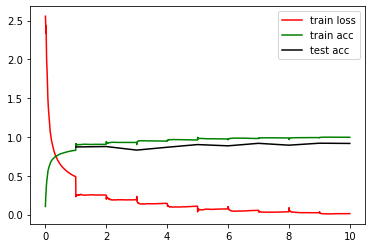

loss 0.013, train acc 0.997, test acc 0.917


In [29]:
lr, num_epochs, batch_size = 0.05, 10, 256
train(net, train_iter, test_iter, num_epochs, lr, try_gpu())